In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os

#sys.path.append(os.path.abspath(os.path.join("../..")))
sys.path.append(os.path.abspath(os.path.join("../scripts")))

In [3]:
import explore
import plot
import clean

In [4]:
cleaned = clean.clean()

# Import The Data

In [5]:
# Data that contains information about the completed orders

data_url = explore.get_data_url("data/complete_orders.csv", "v1.0")
complete_orders = pd.read_csv(data_url)

In [6]:
# Data that contains information about the incomplete orders

data_url = explore.get_data_url("data/missing_orders.csv", "v1.0")
incomplete_orders = pd.read_csv(data_url)

In [7]:
# data driver locations during requests 

data_url = explore.get_data_url("data/clean_driver_locations.csv", "v1.0")
driver_locations = pd.read_csv(data_url)

# Calculate Trips' distances and time durations

## 1. Clean Up latitude and Longitude Data

- First we import geopy to handle coordinates
- Second compare location data to expected values in Lagos, Nigeria

In [8]:
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

boundingbox is a comma separated list of min latitude, max latitude, min longitude, max longitude [see reference](https://nominatim.org/release-docs/develop/api/Output/#boundingbox)

In [9]:
location = geolocator.geocode("Lagos")

lagos_bbox = location.raw['boundingbox']

print("Locations within Lagos-Nigeria are bounded by these values:")
print("latidude: {} - {} \nlongitude: {} - {}".format(*lagos_bbox))



location = geolocator.geocode("Nigeria")

nigeria_bbox = location.raw['boundingbox']

print("\nLocations within Nigeria are bounded by these values:")
print("latidude: {} - {} \nlongitude: {} - {}".format(*nigeria_bbox))


Locations within Lagos-Nigeria are bounded by these values:
latidude: 6.2950575 - 6.6150575 
longitude: 3.2341795 - 3.5541795

Locations within Nigeria are bounded by these values:
latidude: 4.0690959 - 13.885645 
longitude: 2.676932 - 14.678014


Bounds for Lagos-Nigeria should represent soft bounds for our data. We expect locations to be more or less within Lagos bounds.

Hard bounds are represented by bounds for the country of Nigeria. No correct value can exceed these bounds

### 1. complete_orders

In [10]:
# We drop trips whose coordinate fall out of Nigeria boundingbox

print("For coordinates of trip origin:")
complete_orders = cleaned.out_bounds(complete_orders, 'origin_lat', 'origin_lng', nigeria_bbox, drop=True)

print("For coordinates of trip destination:")
complete_orders = cleaned.out_bounds(complete_orders, 'destination_lat', 'destination_lng', nigeria_bbox, drop=True)

For coordinates of trip origin:
There are 0 coordinate values out of bounds, accounting to 0.00% of records.
For coordinates of trip destination:
There are 1 coordinate values out of bounds, accounting to 0.00% of records.


In [11]:
# Trips whose coordinates fall out of Lagos boundingbox

print("For coordinates of trip origin:")
complete_orders = cleaned.out_bounds(complete_orders, 'origin_lat', 'origin_lng', lagos_bbox, drop=False)

print("For coordinates of trip destination:")
complete_orders = cleaned.out_bounds(complete_orders, 'destination_lat', 'destination_lng', lagos_bbox, drop=False)

For coordinates of trip origin:
There are 98891 coordinate values out of bounds, accounting to 18.51% of records.
For coordinates of trip destination:
There are 118894 coordinate values out of bounds, accounting to 22.25% of records.


18.5% of completed orders originate outside of Lagos
22.3% of completed orders go to locations outside of Lagos

### 2. driver_locations

In [12]:
print("Dirvers whose locations at requests fall out of Nigeria boundingbox")

driver_locations = cleaned.out_bounds(driver_locations , 'lat', 'lng', nigeria_bbox, drop=False)

print("\nDirvers whose locations at requests fall out of Lagos boundingbox")

driver_locations = cleaned.out_bounds(driver_locations, 'lat', 'lng', lagos_bbox, drop=False)

Dirvers whose locations at requests fall out of Nigeria boundingbox
There are 0 coordinate values out of bounds, accounting to 0.00% of records.

Dirvers whose locations at requests fall out of Lagos boundingbox
There are 64028 coordinate values out of bounds, accounting to 8.91% of records.


only 8.91% of drivers were outside of Lagos.

### 3. incomplete_orders

In [13]:
# Trips whose coordinates fall out of Lagos boundingbox

print("For coordinates of trip origin:")
incomplete_orders = cleaned.out_bounds(incomplete_orders, 'origin_lat', 'origin_long', lagos_bbox, drop=False)

print("For coordinates of trip destination:")
incomplete_orders = cleaned.out_bounds(incomplete_orders, 'destination_lat', 'destination_long', lagos_bbox, drop=False)

For coordinates of trip origin:
There are 1315 coordinate values out of bounds, accounting to 79.60% of records.
For coordinates of trip destination:
There are 1346 coordinate values out of bounds, accounting to 81.48% of records.


for incomplete orders,  ~ 80% originate or destine to location outside of Lagos.

## 2. Calculate Trips' Durations

In [14]:
complete_orders['trip_start_time'] = pd.to_datetime(complete_orders['trip_start_time'])
complete_orders['trip_end_time'] = pd.to_datetime(complete_orders['trip_end_time'])

In [15]:
complete_orders['trip_duration'] = complete_orders['trip_end_time']- complete_orders['trip_start_time']

# trip duration in hours 
complete_orders['trip_duration_hrs'] = complete_orders['trip_duration'].apply(lambda x: x.seconds/60/60)

In [16]:
complete_orders['trip_duration_hrs'].describe()

count    534305.000000
mean          1.189908
std           1.692039
min           0.000000
25%           0.561389
50%           0.882222
75%           1.335000
max          23.996389
Name: trip_duration_hrs, dtype: float64

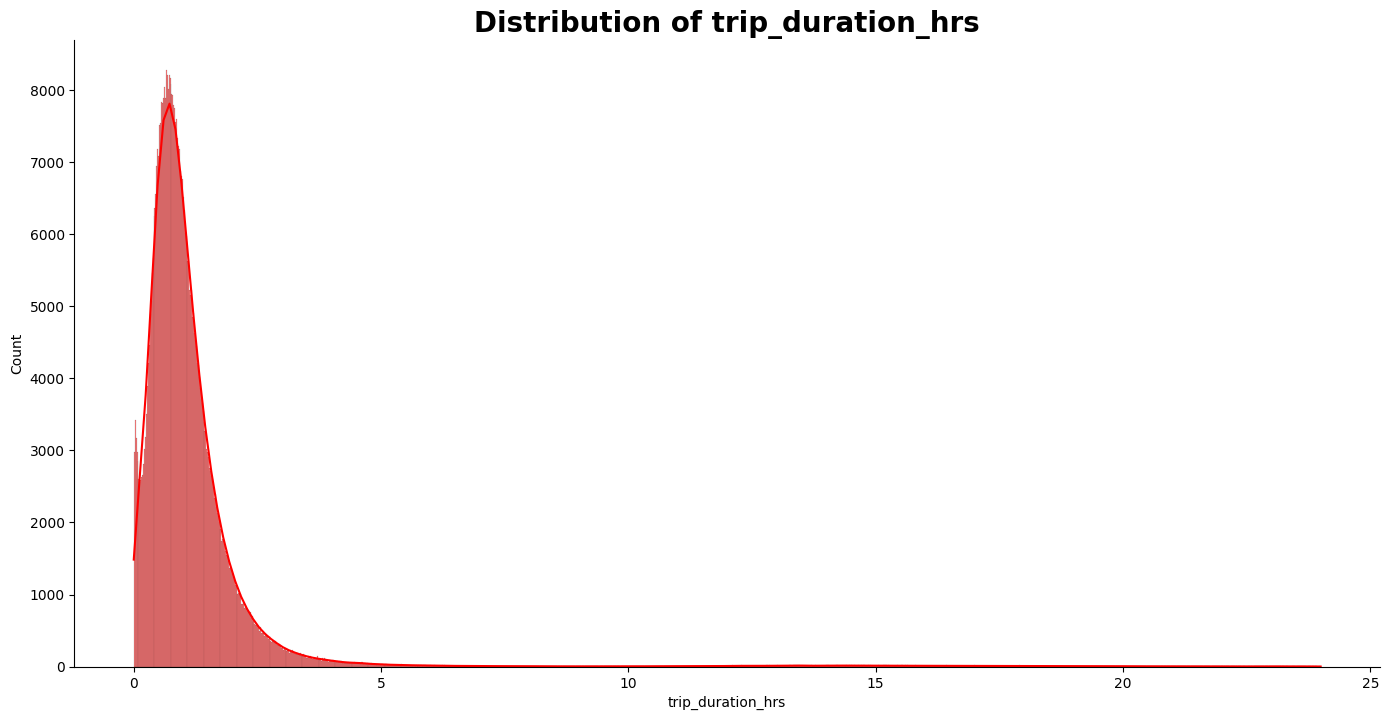

In [ ]:
plot.plot_hist(complete_orders,'trip_duration_hrs', 'red')

There are trips whose duration is too short (less than 5 minutes). Could be that these trips were cancelled

In [17]:
df = complete_orders[complete_orders['trip_duration_hrs']<5/60]

print("{} trips have a duration less than 5 minutes, accounting to {:.2f}% of all orders.".format(len(df),100*len(df)/len(complete_orders)))

13573 trips have a duration less than 5 minutes, accounting to 2.54% of all orders.


## 3. Calculate Trip Distances

Since we have latitude-longitude for starting point and end point. we calculate the straight line distance and not the actual distance traveled along roads.

- we use geopy liberary for calculating distances from lat-long values

- Geopy can calculate geodesic distance between two points using the geodesic distance or the great-circle distance, with a default of the geodesic distance available as the function

In [18]:
from geopy import distance

In [19]:
complete_orders['distance_km'] = complete_orders.apply(lambda x: distance.distance((x['origin_lat'], x['origin_lng']),
(x['destination_lat'], x['destination_lng'])).km, axis=1)

In [20]:
incomplete_orders['distance_km'] = incomplete_orders.apply(lambda x: distance.distance((x['origin_lat'], x['origin_long']),
(x['destination_lat'], x['destination_long'])).km, axis=1)

In [21]:
complete_orders['distance_km'].describe()

count    534305.000000
mean         12.023147
std           8.451186
min           0.000000
25%           5.559767
50%          10.509524
75%          16.992917
max         533.747902
Name: distance_km, dtype: float64

In [22]:
incomplete_orders['distance_km'].describe()

count    1652.000000
mean        3.598481
std         4.325261
min         0.000000
25%         1.246790
50%         2.076392
75%         4.092467
max        43.745229
Name: distance_km, dtype: float64

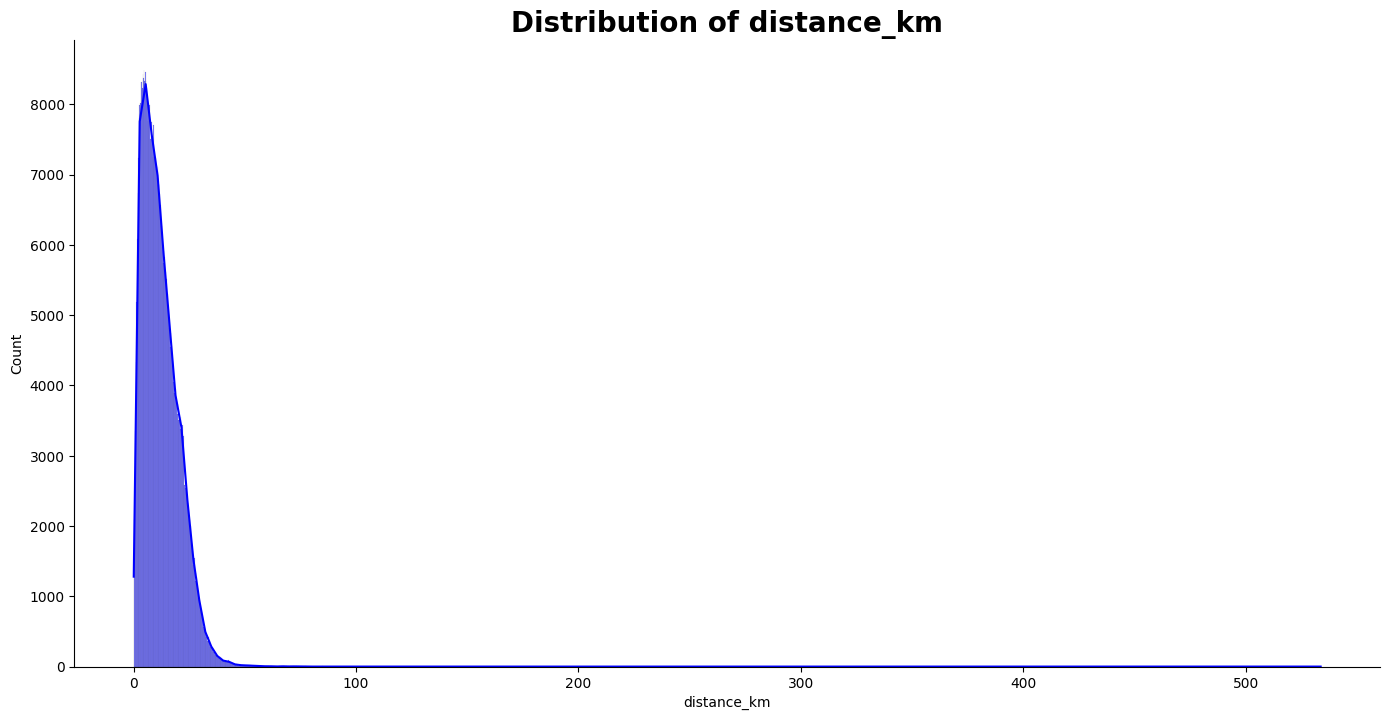

In [25]:
plot.plot_hist(complete_orders,'distance_km', 'blue')

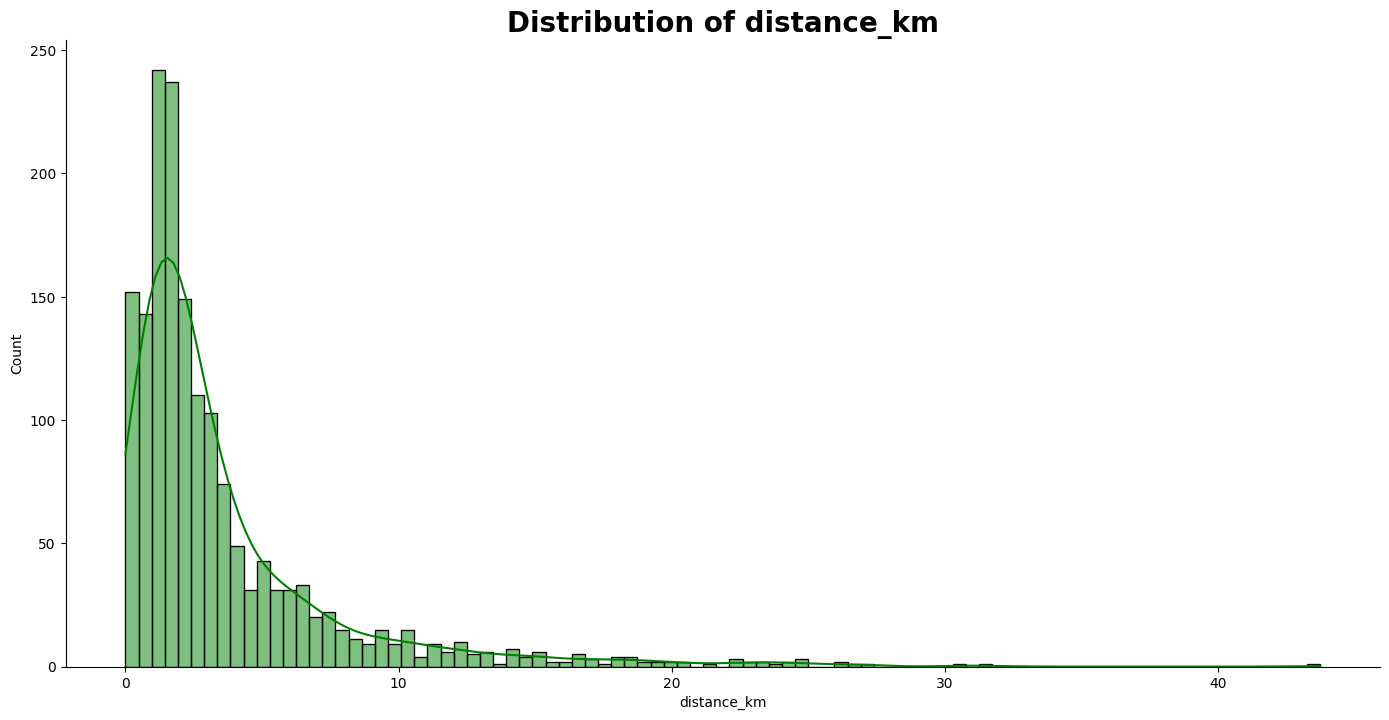

In [26]:
plot.plot_hist(incomplete_orders,'distance_km', 'green')

Perhaps unexpectedly, distance of completed order trends longer than those of incompleted orders.

In [28]:
df = complete_orders[complete_orders['distance_km']< 0.1]

print("{} completed trips of less than 100 meters, accounting to {:.2f}% of all completed orders.".format(len(df), 
100*len(df)/len(complete_orders)))

617 completed trips of less than 100 meters, accounting to 0.12% of all completed orders.


In [29]:
df = incomplete_orders[incomplete_orders['distance_km']< 0.1]

print("{} trips of less than 100 meters, accounting to {:.2f}% of all incomplete orders.".format(len(df), 
100*len(df)/len(incomplete_orders)))

18 trips of less than 100 meters, accounting to 1.09% of all incomplete orders.


# How many drivers Per Order?

We look at the data of drivers, to answer the questions:

- how many drivers are notified per order?
- how many drivers accept or reject per order?

In [30]:
print("full number of records is ", len(driver_locations))

x = driver_locations[['order_id', 'driver_id']].drop_duplicates()

print("However, there are only {} unique pairs of order_id & driver_id".format(len(x)))

full number of records is  718826
However, there are only 611799 unique pairs of order_id & driver_id


We make a couple of observations:

- The combination of 'order_id' + 'driver_id' almost identifies the table of driver location. Although there are cases where the are repeated:

  - There are drivers that have both 'accepted' and 'rejected' actions regarding the same order. These cases could be of a driver that accepted then rejected the order.

- Related, there are orders that get accepted by more than 1 driver. These cases could be that the first driver rejected, so another driver got to accept.

In [31]:
driver_locations.columns

Index(['order_id', 'driver_id', 'driver_action', 'lat', 'lng', 'fulfilled'], dtype='object')

In [35]:
df = pd.DataFrame()

df['order_id'] = driver_locations['order_id']

df['fulfilled'] = driver_locations['fulfilled']

df['driver_id'] = driver_locations['driver_id']

df.drop_duplicates(inplace= True)


drivers_per_orders = df.groupby(['order_id', 'fulfilled']).agg({'driver_id': 'count'})

drivers_per_orders.rename(columns={'driver_id': 'num_drivers'}, inplace=True)

drivers_per_orders.reset_index(inplace=True)

In [45]:
drivers_per_orders[drivers_per_orders['fulfilled']==1].describe()

,order_id,fulfilled,num_drivers
count,26453.000000,26453.0,26453.000000
mean,420027.424148,1.0,23.095490
std,16451.909083,0.0,21.226553
min,392001.000000,1.0,1.000000
25%,405725.000000,1.0,8.000000
50%,420467.000000,1.0,17.000000
75%,433851.000000,1.0,31.000000
max,517948.000000,1.0,215.000000


In [46]:
drivers_per_orders[drivers_per_orders['fulfilled']==0].describe()

,order_id,fulfilled,num_drivers
count,39.000000,39.0,39.000000
mean,420451.358974,0.0,21.897436
std,16849.175708,0.0,18.185875
min,394447.000000,0.0,1.000000
25%,409678.500000,0.0,9.500000
50%,417096.000000,0.0,17.000000
75%,434981.500000,0.0,29.000000
max,447998.000000,0.0,74.000000


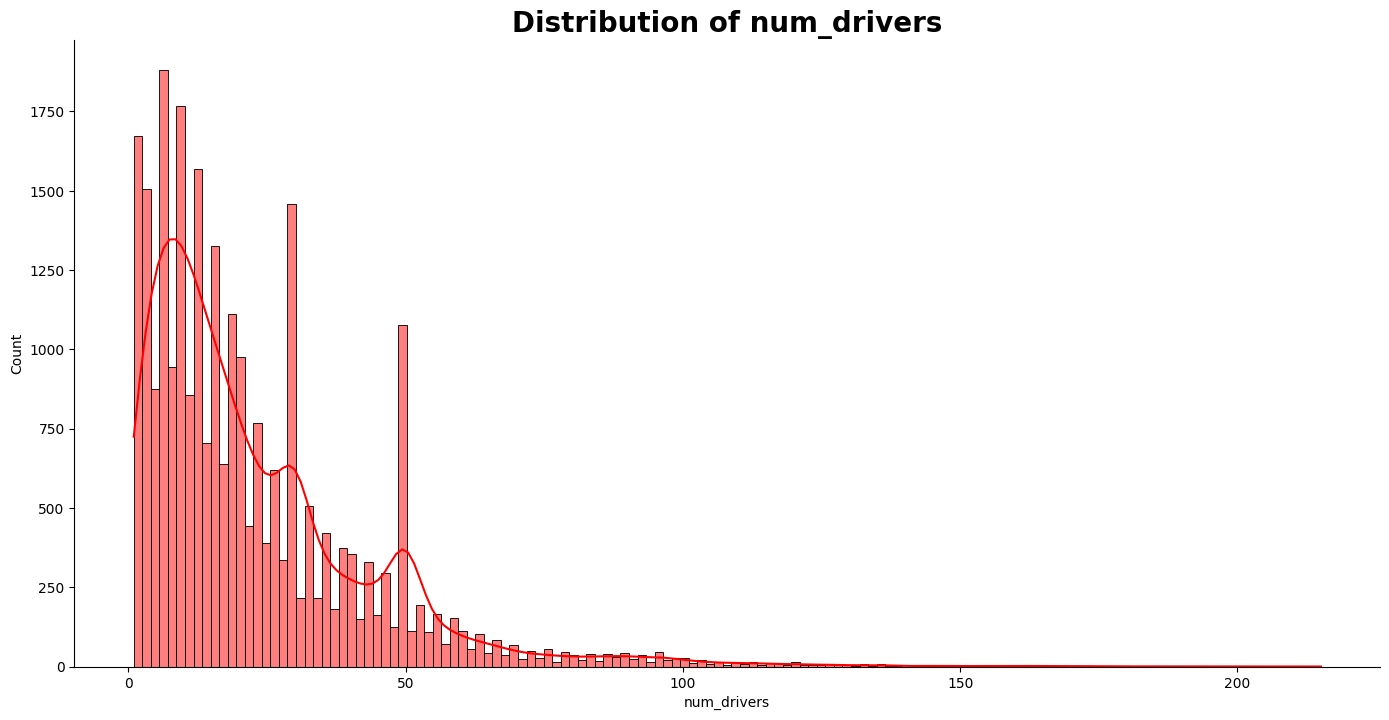

In [42]:
plot.plot_hist(drivers_per_orders[drivers_per_orders['fulfilled']==1], 'num_drivers', 'red')

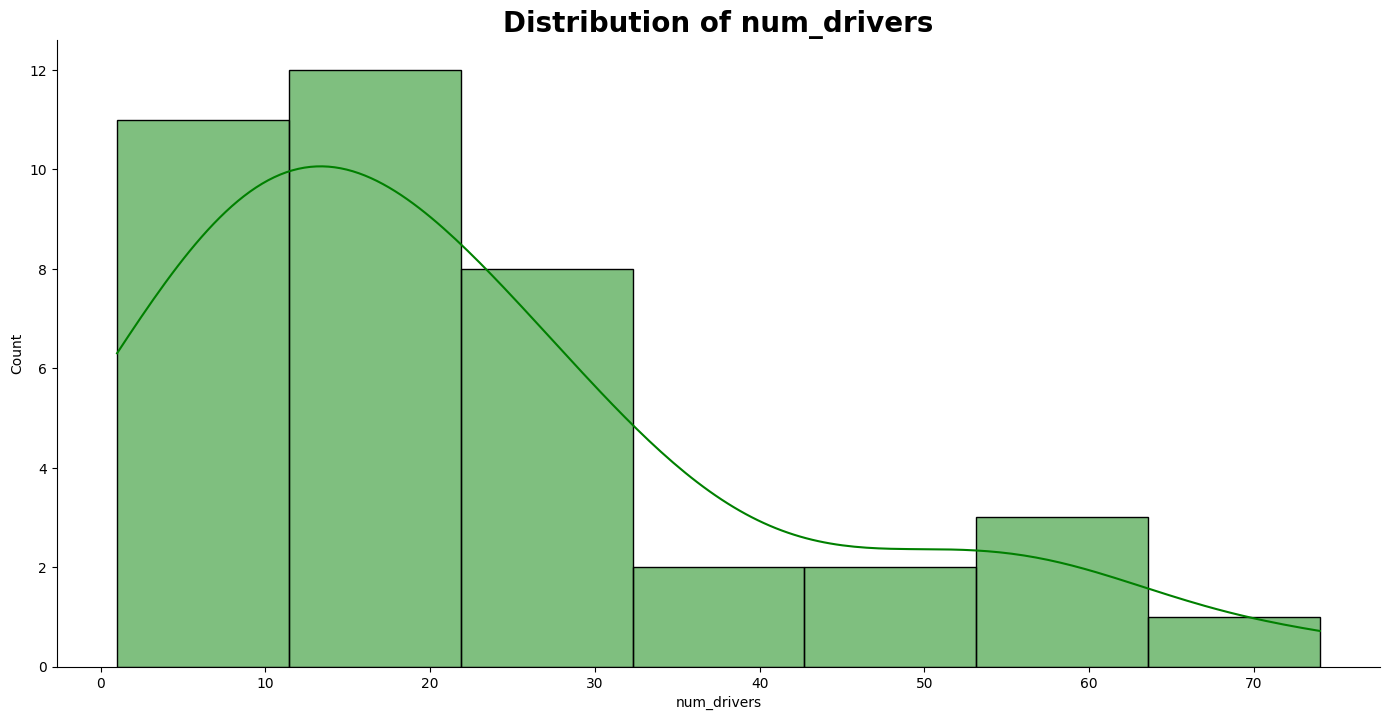

In [44]:
plot.plot_hist(drivers_per_orders[drivers_per_orders['fulfilled']==0], 'num_drivers', 'green')

Comparing fulfilled and unfulfilled orders, we see that the distribution looks similar at lower end (at least 1 driver was notified and the median is around 17). but on average fulfilled orders have more drivers (23 compared to 21).

# Merge order and drivers-location dataframes

We need to merge the two dataframes of fulfilled orders and dirvers locations at request to answer questions like:

- How far are the Drivers at request?

## 1. Merge the dataframes: complete_orders and driver_locations

In [23]:
complete_orders.rename(columns={'distance_km': 'trip_distance_km'}, inplace=True)

complete_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534305 entries, 0 to 534305
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   trip_id            534305 non-null  int64          
 1   trip_start_time    534305 non-null  datetime64[ns] 
 2   trip_end_time      534305 non-null  datetime64[ns] 
 3   origin_lat         534305 non-null  float64        
 4   origin_lng         534305 non-null  float64        
 5   destination_lat    534305 non-null  float64        
 6   destination_lng    534305 non-null  float64        
 7   trip_duration      534305 non-null  timedelta64[ns]
 8   trip_duration_hrs  534305 non-null  float64        
 9   trip_distance_km   534305 non-null  float64        
dtypes: datetime64[ns](2), float64(6), int64(1), timedelta64[ns](1)
memory usage: 44.8 MB


In [25]:
driver_locations.rename(columns={'lat': 'driver_lat', 'lng': 'driver_lng'}, inplace=True)

driver_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718826 entries, 0 to 718825
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       718826 non-null  int64  
 1   driver_id      718826 non-null  int64  
 2   driver_action  718826 non-null  object 
 3   driver_lat     718826 non-null  float64
 4   driver_lng     718826 non-null  float64
 5   fulfilled      718826 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 32.9+ MB


In [26]:
df_merged = pd.merge(complete_orders, driver_locations, how= 'inner', left_on= 'trip_id', right_on= 'order_id')

In [27]:
df_merged.drop(columns=['order_id'], inplace= True)

df_merged.rename(columns={'trip_id': 'order_id'}, inplace= True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717832 entries, 0 to 717831
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   order_id           717832 non-null  int64          
 1   trip_start_time    717832 non-null  datetime64[ns] 
 2   trip_end_time      717832 non-null  datetime64[ns] 
 3   origin_lat         717832 non-null  float64        
 4   origin_lng         717832 non-null  float64        
 5   destination_lat    717832 non-null  float64        
 6   destination_lng    717832 non-null  float64        
 7   trip_duration      717832 non-null  timedelta64[ns]
 8   trip_duration_hrs  717832 non-null  float64        
 9   trip_distance_km   717832 non-null  float64        
 10  driver_id          717832 non-null  int64          
 11  driver_action      717832 non-null  object         
 12  driver_lat         717832 non-null  float64        
 13  driver_lng         717832 non

## 2. Merge the dataframes: incomplete_orders and driver_locations

In [28]:
incomplete_orders.rename(columns={'distance_km': 'trip_distance_km'}, inplace=True)

incomplete_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trip_id           1652 non-null   int64  
 1   origin_lat        1652 non-null   float64
 2   origin_long       1652 non-null   float64
 3   destination_lat   1652 non-null   float64
 4   destination_long  1652 non-null   float64
 5   trip_distance_km  1652 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 77.6 KB


In [29]:
incomplete_merged = pd.merge(incomplete_orders, driver_locations, how= 'inner', left_on= 'trip_id', right_on= 'order_id')

In [30]:
incomplete_merged.drop(columns=['order_id'], inplace= True)

incomplete_merged.rename(columns={'trip_id': 'order_id'}, inplace= True)

incomplete_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          984 non-null    int64  
 1   origin_lat        984 non-null    float64
 2   origin_long       984 non-null    float64
 3   destination_lat   984 non-null    float64
 4   destination_long  984 non-null    float64
 5   trip_distance_km  984 non-null    float64
 6   driver_id         984 non-null    int64  
 7   driver_action     984 non-null    object 
 8   driver_lat        984 non-null    float64
 9   driver_lng        984 non-null    float64
 10  fulfilled         984 non-null    int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 92.2+ KB


## 3. Calculate distances driver-trip origin 

In [31]:
from geopy import distance

In [33]:
df_merged['driver-origin_km'] = df_merged.apply(lambda x: distance.distance((x['origin_lat'], x['origin_lng']),
(x['driver_lat'], x['driver_lng'])).km, axis=1)

df_merged['driver-dest_km'] = df_merged.apply(lambda x: distance.distance((x['destination_lat'], x['destination_lng']),
(x['driver_lat'], x['driver_lng'])).km, axis=1)

In [34]:
incomplete_merged['driver-origin_km'] = incomplete_merged.apply(lambda x: distance.distance((x['origin_lat'], x['origin_long']),
(x['driver_lat'], x['driver_lng'])).km, axis=1)

incomplete_merged['driver-dest_km'] = incomplete_merged.apply(lambda x: distance.distance((x['destination_lat'], x['destination_long']),
(x['driver_lat'], x['driver_lng'])).km, axis=1)

In [35]:
df_merged[['driver-origin_km', 'driver-dest_km']].describe()

,driver-origin_km,driver-dest_km
count,717832.000000,7.178320e+05
mean,1.790051,9.525378e+00
std,1.088520,6.873024e+00
min,0.000000,3.071491e-12
25%,1.067051,4.402384e+00
50%,1.687462,7.806586e+00
75%,2.398366,1.298262e+01
max,210.887483,7.754643e+01


In [36]:
incomplete_merged[['driver-origin_km', 'driver-dest_km']].describe()

,driver-origin_km,driver-dest_km
count,984.000000,984.000000
mean,1.657023,5.802816
std,1.003861,4.512974
min,0.008076,0.093253
25%,1.012555,2.492267
50%,1.571920,4.513878
75%,2.291668,8.124747
max,13.066181,19.593464


- The general distribution of distances to origin is similar for complete and incomplete orders.

- For complete orders, looking at the max value (>200km) and the 75% quantile (< 3 km). it is clear that there are outliers.

- Since there are other values (lat-lng and driver_action) that are related to distance, we handle the outliers by removing them

In [37]:
df = cleaned.drop_outlier(df_merged, 'driver-origin_km', alpha= 0.001)
#df = cleaned.drop_outlier(df, 'driver-dest_km', alpha= 0.001)

print(len(df_merged) - len(df))

718


# 4. Drivers within 500 m

In [39]:
 # for completed orders

df500 = df[df['driver-origin_km'] <= 0.5]

drivers_within500m = df500.groupby('order_id').agg({'trip_duration_hrs': 'mean', 'trip_distance_km': 'mean','driver_id': 'count', 
'driver-origin_km': 'mean', 'driver-dest_km': 'mean'})

drivers_within500m.reset_index(inplace=True)

In [42]:
drivers_within500m.describe()

,order_id,trip_duration_hrs,trip_distance_km,driver_id,driver-origin_km,driver-dest_km
count,15139.000000,15139.000000,15139.000000,15139.000000,15139.000000,1.513900e+04
mean,418910.021996,0.992006,10.530392,4.240306,0.307752,1.053081e+01
std,16282.068816,1.547779,7.432151,7.909841,0.112178,7.433185e+00
min,392009.000000,0.005000,0.016387,1.000000,0.000000,3.071491e-12
25%,404389.500000,0.445833,4.785129,1.000000,0.232972,4.786964e+00
50%,419402.000000,0.732222,8.847153,2.000000,0.318550,8.853055e+00
75%,432242.000000,1.124167,14.742229,3.000000,0.393565,1.473244e+01
max,517948.000000,23.793056,77.546433,101.000000,0.499967,7.754643e+01


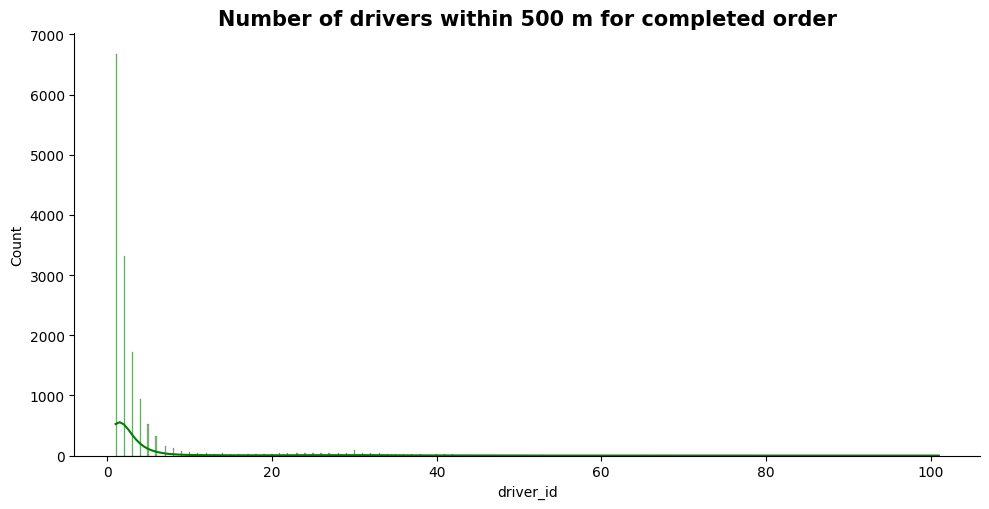

In [43]:
sns.displot(drivers_within500m, x= 'driver_id', color='green', kde=True, height=5, aspect=2)
plt.title('Number of drivers within 500 m for completed order', size=15, fontweight='bold')
plt.show()

For most cases, there are less than 5 drivers within 500 m of an order.

In [45]:
# for incomplete orders

df500 = incomplete_merged[incomplete_merged['driver-origin_km'] <= 0.5]

in_drivers_within500m = df500.groupby('order_id').agg({'trip_distance_km': 'mean','driver_id': 'count', 
'driver-origin_km': 'mean', 'driver-dest_km': 'mean'})

in_drivers_within500m.reset_index(inplace=True)

In [46]:
in_drivers_within500m.describe()

,order_id,trip_distance_km,driver_id,driver-origin_km,driver-dest_km
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,420852.681818,5.318194,5.045455,0.293220,5.347136
std,18289.809719,4.067936,7.773442,0.090722,3.992027
min,394447.000000,0.875191,1.000000,0.167691,1.015435
25%,404122.000000,3.009994,2.000000,0.237647,2.963478
50%,424877.000000,3.958945,3.000000,0.277543,3.980097
75%,435666.750000,6.900587,4.000000,0.346284,6.800678
max,447888.000000,18.596787,36.000000,0.491354,18.590107


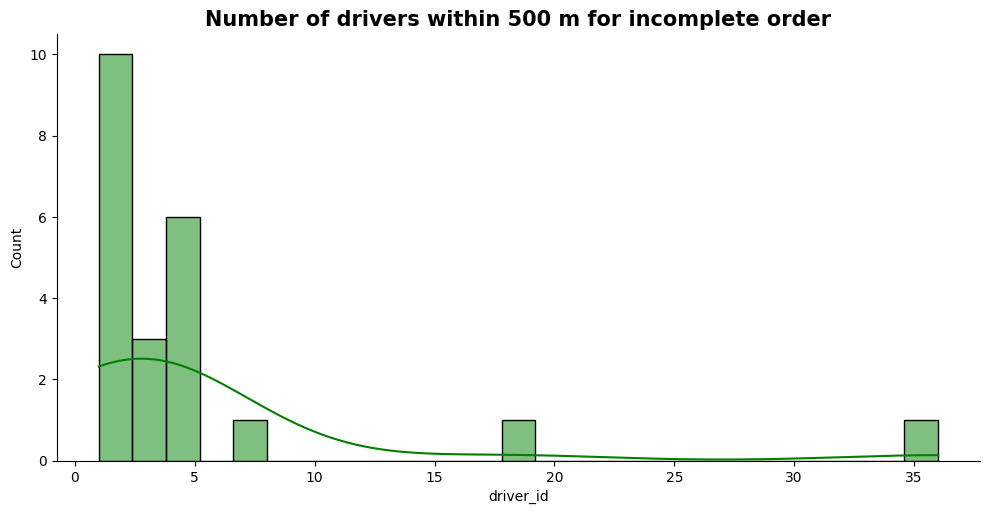

In [47]:
sns.displot(in_drivers_within500m, x= 'driver_id', color='green', kde=True, height=5, aspect=2)
plt.title('Number of drivers within 500 m for incomplete order', size=15, fontweight='bold')
plt.show()

# Write out the data

In [48]:
complete_orders.to_csv('../data/complete_orders.csv', index=False)

In [49]:
incomplete_orders.to_csv('../data/missing_orders.csv', index=False)

In [50]:
driver_locations.to_csv('../data/clean_driver_locations.csv', index=False)

In [51]:
df.to_csv("../data/clean_merged.csv", index=False)

In [52]:
incomplete_merged.to_csv("../data/incomplete_merged.csv", index=False)